In [1]:
from helpers.utilities import *
%run helpers/notebook_setup.ipynb

In [2]:
%R source('plots/colors.R');

Inputs:

In [3]:
__inputs__ = create_paths(
    path='data/integration/',
    csv=[
        'rna', 'rna_shared', 'protein', 'protein_shared',
        'patients_with_both', 'genes_in_both', 'patient_annotations_ordered'
    ]
)
clinical_path = 'data/clean/clinical/data_with_derived_variables.csv'

In [4]:
load_inputs(
    globals(), silent=True,
    loaders={'patients_with_both': Series.from_csv, 'genes_in_both': Series.from_csv},
)

In [5]:
patients_union = list(rna.columns | protein.columns) 
clinical = read_csv(clinical_path, index_col=0).loc[patients_union]
from plots.annotations import generate_patient_annotations
patient_annotations = generate_patient_annotations(clinical)

# Simple PLS regression

Toolkit: PLSRegression in sklearn has multiple issues (and it has no maintainer as non of the core developers use it). Thus it may not be the best implementation of the algorithm (plus I looked though it and there are minor modifications to the reference from Wold that I do not fully understand yet). But as a first step it was "good enough":

In [6]:
from sklearn.cross_decomposition import PLSRegression, PLSCanonical

According to the documentation, `PLSRegression` produces results equivalent to:
>- "mixOmics" with function `pls(X, Y, mode = "regression")`
>- "plspm " with function `plsreg2(X, Y)`
>- "pls" with function `oscorespls.fit(X, Y)`

while `PLSCanonical`:
 > implements the 2 blocks canonical PLS of the original Wold algorithm [Tenenhaus 1998] p.204, referred as PLS-C2A in [Wegelin 2000].

Both use NIPALS algorithm (sklearn version 'A'); the differences are in:
 - the deflation_mode (regression/canonical); this changes meaning of P & Q (regression of X vs regression of Y)
 - normalization of y weights (no/yes)
 
Notes: S. Wold et al, 2001 uses norm_y_weights=yes (p. 118, step E)

Known bugs in sklearn PLS implementation:
 - values are are not rescaled back after prediction
 - https://github.com/scikit-learn/scikit-learn/issues/4122

$${\displaystyle X=TP^{\mathrm {T} }+E}$$
$${\displaystyle Y=UQ^{\mathrm {T} }+F}$$

In [7]:
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.model_selection import GroupKFold, GroupShuffleSplit, RepeatedKFold, LeaveOneOut, ShuffleSplit

1. Assessing performance and choosing number of latent variables with cross-validation
2. Applying to the entire dataset for exploration
3. Analysis of latent factors

As suggested I will focus on the TMD-CM subset:

In [8]:
cm_and_tmd = patients_with_both[patients_with_both.str.contains('TMD|CM')]

In [9]:
rs = rna.loc[genes_in_both, cm_and_tmd]
ps = protein.loc[genes_in_both, cm_and_tmd]

In [10]:
def patient_counts(data):
    return DataFrame({
        k: v.columns.map(clinical.Meningitis).value_counts()
        for k, v in data.items()
    })

In [11]:
patient_counts({'RNA': rs, 'Protein': ps})

,RNA,Protein
Cryptococcal,14,14
Tuberculosis,7,7


However as there are only 7 patients, this may not be enough for a sensible model. For PLS-DA this would mean learning on 4-5 TB patients and testing on two, which will lead to all sorts of problems.

In [12]:
# using full TB data is one way to workaround low number of TMD samples for PLS-DA
cm_and_tm = patients_with_both[patients_with_both.str.contains('TMD|TMS|TMR|CM')]

## A) Integration: regressing genes (PLS: TMD & CM)

(X=RNA, Y=Protein, observations=transcripts/proteins)

hypothesis: there are subgroups of patients for which the RNA-Protein balance is different than for others (as I have demonstrated above, there are hints that different signaling processes may underlay such potential stratification)

While for the PLS-DA I need an exact correspondence of observations (for DA model: patients), for the PLS model which would look at the gene-protein relation I could include all patients (not only those for whom the data are shared):

In [13]:
p = protein.loc[genes_in_both,protein.columns.str.contains('TMD|CM')]
r = rna.loc[genes_in_both,rna.columns.str.contains('TMD|CM')]

In [14]:
patient_counts({'RNA': r, 'Protein': p})

,RNA,Protein
Cryptococcal,17,24
Tuberculosis,12,13


In [15]:
# Note; one could argue that the normalization should happen after split
X_train, X_test, Y_train, Y_test = train_test_split(r, p, random_state=0)

In [16]:
X_train.head(2)

,001.TMD,006.CM,016.CM,017.TMD,018.CM,...,206.CM,185.TMD,174.CM,078.CM,261.CM
DDX19B,-1.18943,1.068422,4.319018,4.067491,3.883897,...,3.728469,2.687380,3.739893,4.676069,4.565402
PRSS1,-1.18943,-1.189430,2.665447,-1.189430,-1.189430,...,2.878618,3.325784,2.200563,-0.675254,2.354802


### Learning process visualization

In [17]:
genes_for_viz = Series(genes_in_both).sample(100)
r.loc[genes_for_viz].to_csv('.r.csv')
p.loc[genes_for_viz].to_csv('.p.csv')

See PLS.ipynb for videos with animation.

### Using sklearn

#### Choosing the number of latent factors

In [18]:
from sklearn.model_selection import GridSearchCV

In [19]:
tuned_parameters = [
    # giving two conditions (TMD and CM) we expect at least two components
    {'n_components': range(1, 20)}
]

Wold et al, 2001 described two cross-validation based procedures to asses the number of PLS components $A$ (3.8):
 - "sequential", which needs to be integrated into the PLS algorithm, and
 - "total", which is a standard re-run of the algorithm
 
and both are expected to give similar results (p. 117).

The objective is the minimal predictive residual sum of squares (PRESS) divided by a measure of dimensionality reduction:

$$\frac{\text{PRESS}}{N - A -1}$$

where $N$ is the total number of observations.

TODO: $R^2$ formulation is also used, though not sure about the use for "total" procedure.

In [20]:
from sklearn import metrics

In [21]:
def weighted_press(estimator, x, y):
    # Note: it looks in the publication like they define N before CV
    # (though I am not sure) but this this should not make a big difference
    N = estimator.x_scores_.shape[0]
    A = estimator.n_components
    return metrics.mean_squared_error(estimator.predict(x), y) / (N - A - 1)

In [22]:
from helpers.pls import custom_scorer, format_grid_results
from functools import partial

cv_scoring = {
    '-PRESS/(N-A-1)': custom_scorer(weighted_press, greater_is_better=False),
    'r2_score': 'r2'
}

cv = RepeatedKFold(n_splits=3, n_repeats=3, random_state=0)

press_grid_search = partial(
    GridSearchCV,
    cv=cv,
    scoring=cv_scoring,
    refit='-PRESS/(N-A-1)'
)

In [23]:
reg = press_grid_search(PLSRegression(scale=T), param_grid=tuned_parameters)
reg.fit(X_train, Y_train);
reg.best_params_

{'n_components': 3}

In [24]:
grid_results = format_grid_results(reg)
grid_results.head(2)

,param_n_components,variable,value,scoring,split
0,1.0,split0_test_-PRESS/(N-A-1),-0.022166,-PRESS/(N-A-1),0
1,2.0,split0_test_-PRESS/(N-A-1),-0.021561,-PRESS/(N-A-1),0


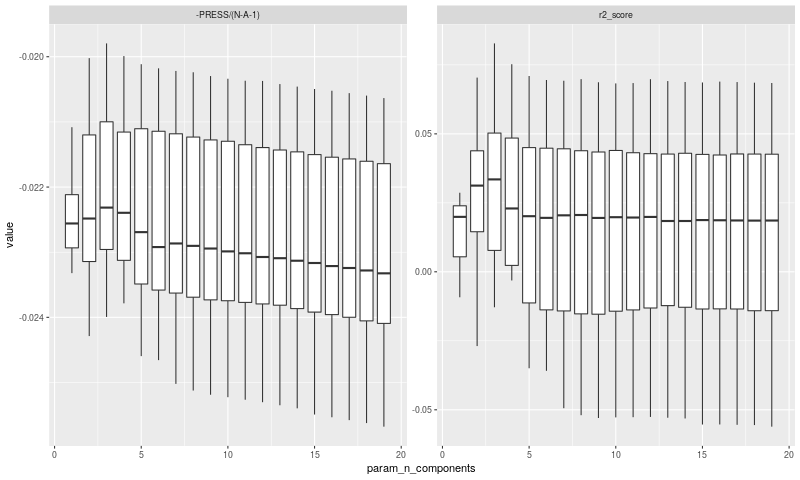

In [25]:
%%R -i grid_results -w 800
grid_search_plot = function(grid) { 
    (
        ggplot(grid, aes(
            y=value,
            group=param_n_components,
            x=param_n_components
        ))
        + facet_wrap('scoring', scale='free_y')
        + geom_boxplot()
    )
}
grid_search_plot(grid_results)

Note: The number of latent factors could be further verified using multiscale bootstrapping. But on observations or on features?

In [26]:
Y_true, Y_pred = Y_test, reg.predict(X_test)
metrics.r2_score(Y_true, Y_pred)

0.03307800639323379

0.03 is not a very good performance.

- I also tried using the RLE normalization, getting very similar results for all models.
- PLSCanonical has always negative R^2 in this scenario

Applying to the full dataset:

In [27]:
# use of my custom Pandas* wrappers allows to easily access
# the resulting matrices in DataFrame form
from helpers.pls import PandasPLSCanonical, PandasPLSRegression

In [28]:
pls = PandasPLSRegression(n_components=3, scale=F)

In [29]:
# even on the full learning data it is not overfitting too much (as this is not so easy with n=3)
r_scores, p_scores = pls.fit_transform(r, p)
pls.score(r, p)

0.07240807187136496

In [30]:
# but let's keep the test separate:
pls.fit(X_train, Y_train)
train_r_scores, train_p_scores = pls.transform(X_train, Y_train)
test_r_scores, test_p_scores = pls.transform(X_test, Y_test)
pls.score(X_test, Y_test)

0.0424747754728533

In [31]:
from helpers.pls import format_test_train_scores

scores = format_test_train_scores(
    train_r_scores, train_p_scores,
    test_r_scores, test_p_scores
)

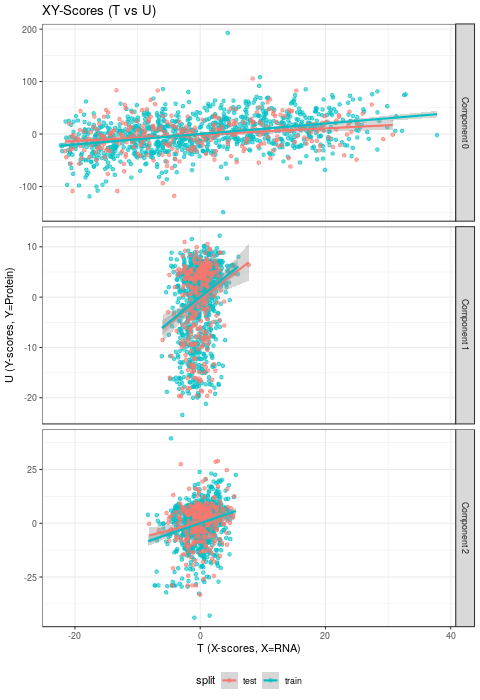

In [32]:
%%R -i scores -h 700

labels = list(
    'T'='T (X-scores, X=RNA)',
    'U'='U (Y-scores, Y=Protein)'
)

plot_xy_scores = function(scores) {
    (
        ggplot(scores, aes(x=T, y=U, color=split))
        + facet_grid('component', labeller=function(i){lapply(i, FUN=function(x) paste('Component', x))}, scale='free')
        + geom_point(alpha=0.6)
        + geom_smooth(method='lm')
        + nice_theme
        + labs(x=labels['T'], y=labels['U'])
        + ggtitle('XY-Scores (T vs U)')
    )
}
plot_xy_scores(scores)

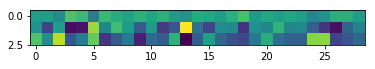

In [33]:
import matplotlib.pyplot as plt
plt.imshow(pls.W.T);

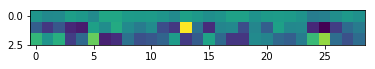

In [34]:
plt.imshow(pls.P.T);

Which patients provide the most value?

In [35]:
w = pls.W

In [36]:
patient_annotations_ordered['Is RNA outlier'] = patient_annotations_ordered['Is RNA outlier'].astype(str)

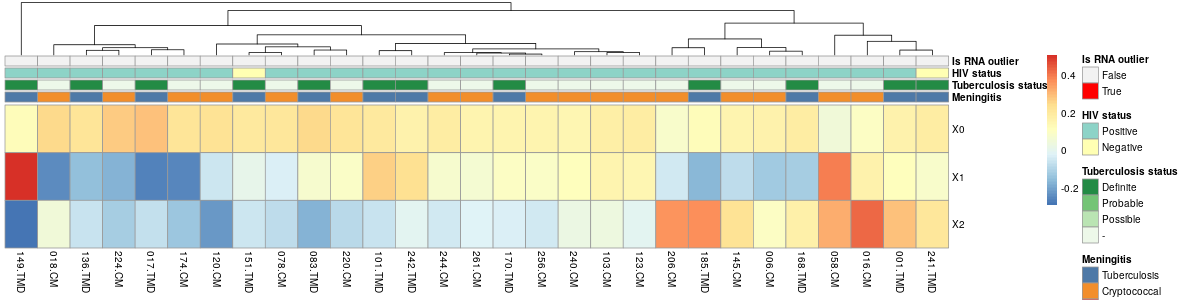

In [37]:
%%R -i w -i patient_annotations_ordered -w 1200 -h 300
import::here(space_to_dot, dot_to_space, remove_leading_X, .from='helpers/utilities.R')
names(patient_annotations_ordered) = dot_to_space(names(patient_annotations_ordered))

weights_heatmap = function(w, annotation=patient_annotations_ordered, ...) {
    w = t(w)
    colnames(w) <- remove_leading_X(colnames(w))

    pheatmap::pheatmap(
        w,
        show_colnames=T, show_rownames=T,
        annotation_col=annotation,
        annotation_colors=patient_colors,
        cluster_rows=F, cluster_cols=T
    )
}

weights_heatmap(w)

In [38]:
# w = w.reset_index()

In [39]:
pls.Q.T

,149.TMD,007.TMD,001.TMD,064.TMD,151.TMD,...,229.CM,240.CM,244.CM,247.CM,256.CM
0,0.043941,0.046742,0.051739,0.045880,0.050929,...,0.019560,0.036698,0.043128,0.031337,0.029658
1,-0.361502,-0.307136,-0.450657,-0.345924,-0.363321,...,-0.519981,-0.439096,-0.452855,-0.499532,-0.441410
2,-0.218298,-0.206634,-0.218469,-0.233966,-0.251942,...,-0.077552,-0.146341,-0.202034,-0.096906,-0.190624


TODO:
- what is the stability of the latent factors upon bootstrapping?
- what are the latent factors?
- add correlations coefficients above, add plots for other combinations
- loadings plot (!!!!!!)

### Using rOPLS

In rOPLS by default the data are mean-centered and unit variance scaled.

In [40]:
%R import::here(plot_opls, plot_opls_all, plot_summary, run_and_plot_opls, .from='plots/ropls.R')

In [41]:
%R -i X_train -i Y_train

In [42]:
%R -i r -i p

In [43]:
%R pca = ropls::opls(r);

PCA
1255 samples x 29 variables
standard scaling of predictors
      R2X(cum) pre ort
Total     0.75   1   0


Just one significant RNA component in PCA

In [44]:
%R pca = ropls::opls(p);

PCA
1255 samples x 37 variables
standard scaling of predictors
      R2X(cum) pre ort
Total    0.944   1   0


Same for protein. TODO what are the criteria used for significance?

In [45]:
%R model = ropls::opls(r, as.matrix(p));

PLS
1255 samples x 29 variables and 37 responses
standard scaling of predictors and response(s)
      R2X(cum) R2Y(cum) Q2(cum) RMSEE pre ort
Total    0.767    0.066  0.0396  3.67   2   0


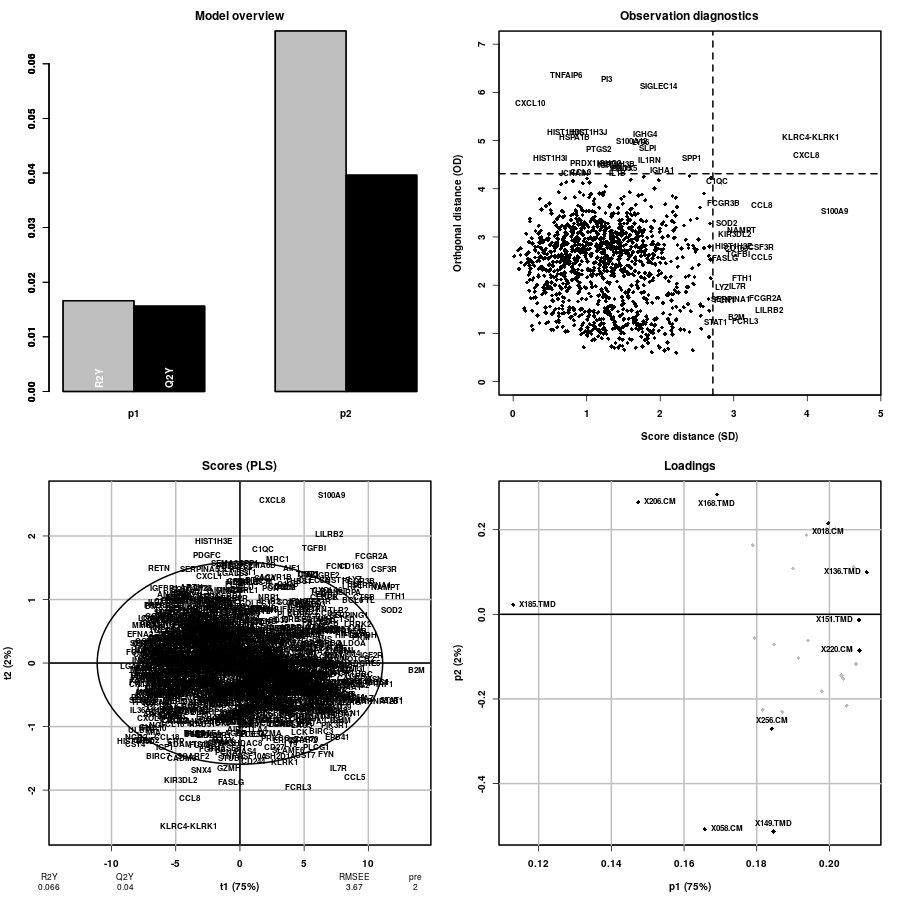

In [46]:
%%R -w 900 -h 900
plot_summary(model)

> Figure 1: PCA summary plot. Top left overview: the scree plot (i.e., inertia barplot) suggests that 3 components may be sufficient to capture most of the inertia; Top right outlier: this graphics shows the distances within and orthogonal to the projection plane (Hubert, Rousseeuw, and Vanden Branden 2005): the name of the samples with a high value for at least one of the distances are indicated; Bottom left x-score: the variance along each axis equals the variance captured by each component: it therefore depends on the total variance of the dataMatrix X and of the percentage of this variance captured by the component (indicated in the labels); it decreases when going from one component to a component with higher indice; Bottom right x-loading: the 3 variables with most extreme values (positive and negative) for each loading are black colored and labeled. (https://bioconductor.org/packages/release/bioc/vignettes/ropls/inst/doc/ropls-vignette.html)

Now, interpretation of this model is not obvious. We cannot claim anything about difference between conditions nor do we have a healthy control here.

The goal was to see whether there are any groups of transcript-protein pairs which behave differently to majority (so being negatively correlated or maybe extremely positively correlated). This model may not be sufficient to answer this question because there are only two components.

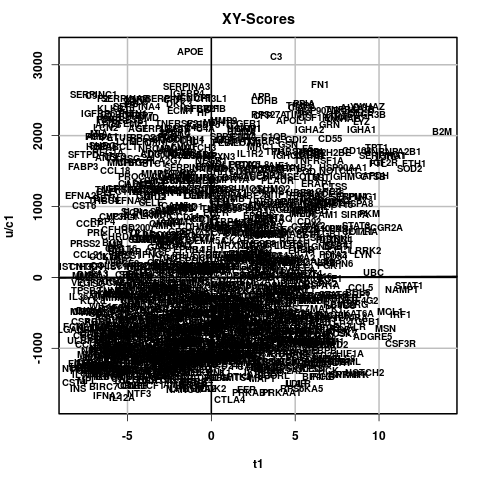

In [47]:
%R plot_opls(model, 'xy-score')

So it reflects the general relation (positive correlation).

Better results may be obtained enforcing more components. Additionally, separating conditions into two models would enable some sort of comparison.

An additional use of this model is in the T scores interpretation; ultimately, this is like PCA on RNASeq but aware of the impact on the protein levels. I think of it as a weighting which makes PCA components potentially more relevant.

As this describes both the groups (TMD and CM), I expect to find HIV related genes here rather than genes related to TB/CM as those would be differential:

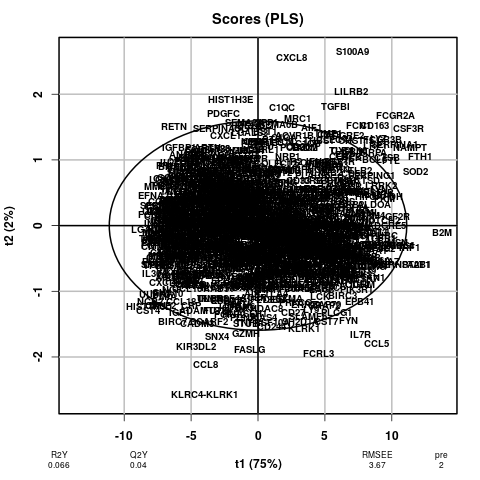

In [48]:
%R plot_opls(model, 'x-score')

Note: The data are scaled (z-score).

A few words on some (arbitrarily) chosen genes which span the X-scores:

T1 top 3:

- KLRK1 "killer cell lectin like receptor K1", "Natural killer (NK) cells are lymphocytes that can mediate lysis of certain tumor cells and virus-infected cells without previous activation. They can also regulate specific humoral and cell-mediated immunity.", "The surface expression of these ligands is important for the recognition of stressed cells by the immune system, and thus this protein and its ligands are therapeutic targets for the treatment of immune diseases and cancers. Read-through transcription exists between this gene and the upstream KLRC4"
- S100A9 - Toll-Like Receptors Cascades, IL-17, Neutrophil degranulation, Antimicrobial peptide, HIV infection decreases levels
- CXCL8 - Interleukin 8; many HIV interactions; many pathways

T2 top 3:
- B2M: β2-microglubulin: related to MHC, HIV Infection (Host Interactions), IL-12, interferon, TCR singaling;
 - **the most highly expressed**, see point 6
- HIST1H3D: - "HIV-1 Tat peptides bind core histones H2A, H2B, H3 and H4, and Tat protein recruits histone acetyltransferases to the HIV-1 LTR promoter leading to acetylation of histones H3 and H4, derepressing chromatin structure and increasing NFkappaB responsiveness":
 - **absent in TMD** (and almost absent in most of TM), see point 1,
 - **the most highly negatively correlated gene-protein pair**, see point 4
- CST4: cystatin S "cysteine proteinase inhibitors found in a variety of human fluids and secretions" "high level of expression in saliva, tears and seminal plasma. The specific role in these fluids is unclear but antibacterial and antiviral activity is present, consistent with a protective function"
 - perfect correlation but very little support, see point 7.2

### AA) Regressing genes with late integration

and more components enforced

In [49]:
p_tmd = protein.loc[genes_in_both,protein.columns.str.contains('TMD')]
p_cm = protein.loc[genes_in_both,protein.columns.str.contains('CM')]
r_tmd = rna.loc[genes_in_both,rna.columns.str.contains('CM')]
r_cm = rna.loc[genes_in_both,rna.columns.str.contains('CM')]

In [50]:
%R -i p_tmd -i p_cm -i r_tmd -i r_cm

Number of components chosen to maximize it but keep positive Q2 (preventing overfiting) the forced increase in number of latent factors comes at expense of overfitted model:

In [51]:
%R model_tmd = ropls::opls(r_tmd, as.matrix(p_tmd), predI=4);

PLS
1255 samples x 17 variables and 13 responses
standard scaling of predictors and response(s)
      R2X(cum) R2Y(cum) Q2(cum) RMSEE pre ort
Total    0.851   0.0644  0.0215  3.64   4   0


In [52]:
%R model_cm = ropls::opls(r_cm, as.matrix(p_cm), predI=4);

PLS
1255 samples x 17 variables and 24 responses
standard scaling of predictors and response(s)
      R2X(cum) R2Y(cum) Q2(cum) RMSEE pre ort
Total    0.851   0.0591  0.0138  3.71   4   0


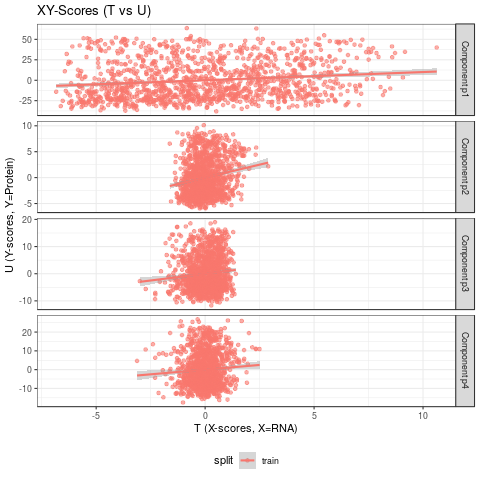

In [53]:
%%R
melt_xy_scores = function(model, split_name='train') {
    t = reshape2::melt(model@scoreMN, value.name='T', varnames=c('gene', 'component'))
    u = reshape2::melt(model@uMN, value.name='U', varnames=c('gene', 'component'))
    tu = merge(t, u, by=c('gene', 'component'))
    tu$split = split_name
    tu
}
scores = melt_xy_scores(model_tmd)
plot_xy_scores(scores)

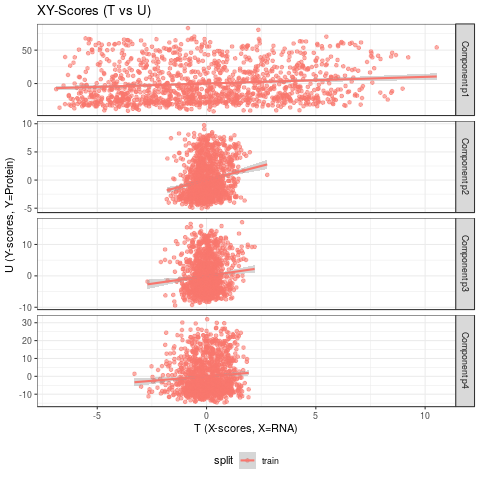

In [54]:
%%R
scores = melt_xy_scores(model_cm)
plot_xy_scores(scores)

In both cases all the components model positive relation. The modeled relations are similar.

The scale difference shows how the most of the protein variation is captured in the first component.

## B) Early integration by profiles (PLS: TMD & CM, observations=patients)

Again, here I could include all transcript/proteins:

In [55]:
ra = rna.loc[:, cm_and_tmd].T
pa = protein.loc[:, cm_and_tmd].T

In [56]:
X_train, X_test, Y_train, Y_test = train_test_split(ra, pa, random_state=0)

In [57]:
from warnings import catch_warnings
reg = press_grid_search(PLSRegression(scale=F), param_grid=[
    {
        'n_components': range(
            1,
            # we cannot have more components than observations
            # (and in cros-validation there are fewer observations available)
            min(len(a) for a, b in cv.split(X_train))
        )
    }
])

with catch_warnings(record=T) as w:
    reg.fit(X_train, Y_train);

print(len(w), 'warnings')
reg.best_params_, reg.best_score_

19 warnings


({'n_components': 1}, -0.08993526572996823)

In [58]:
reg.best_estimator_.score(X_train, Y_train)

0.24173142961877053

In [59]:
grid_results = format_grid_results(reg)

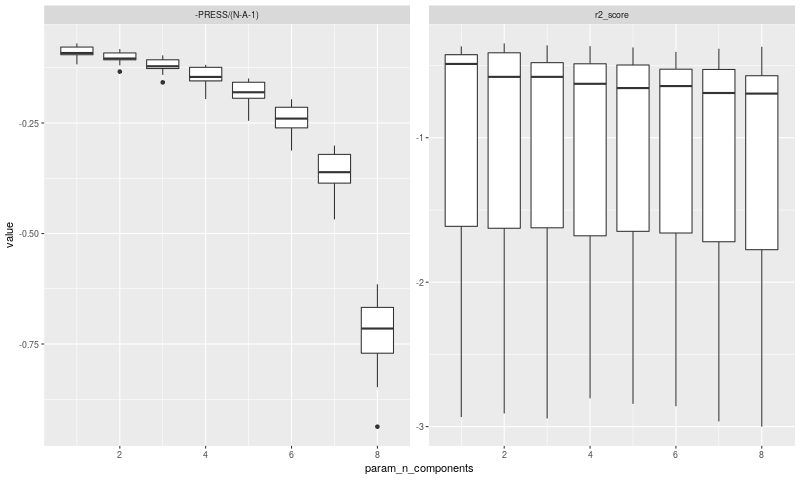

In [60]:
%%R -i grid_results -w 800
grid_search_plot(grid_results)

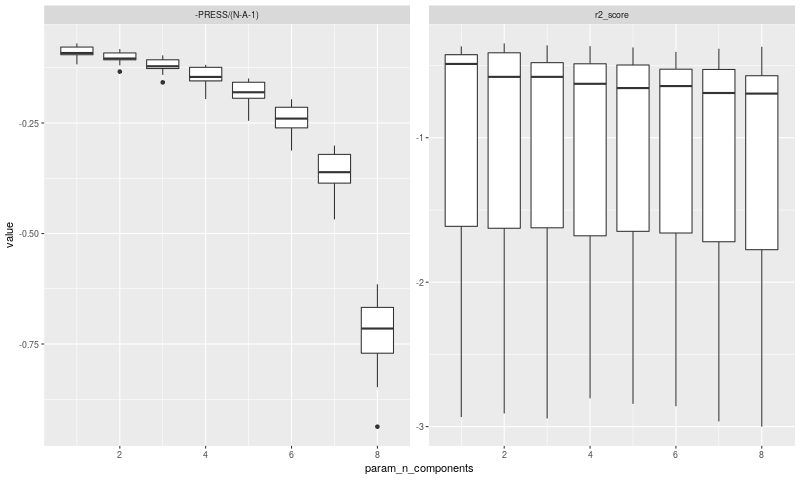

In [61]:
%%R -i grid_results -w 800
grid_search_plot(grid_results)

TODO: should I replace values below 0 (having very little reads in RNASeq, so that after log transformation the value is < 0) with nan?

In [62]:
pls = PandasPLSRegression(n_components=1, scale=F)
pls.fit(X_train, Y_train)
pls.score(X_test, Y_test)

-0.24234142268902784

In [63]:
w = pls.W

In [64]:
%%R -i w -w 1200 -h 300
# well, this is quite useless with just one component
# weights_heatmap(w, annotation=NA)

NULL


But I still could do pathway analysis on 1 component....

### Using mixOmics

In [65]:
%%R -i X_train -i Y_train
p = mixOmics::pls(X_train, Y_train, ncomp=3)
p$explained_variance

$X
    comp 1     comp 2     comp 3 
0.20915864 0.09600080 0.06646587 

$Y
   comp 1    comp 2    comp 3 
0.3057144 0.1784427 0.1253515 



In [66]:
%%R -i X_test
# It is not immediately obvious how to combine layers in Y_predict
Y_predict = predict(p, X_test)

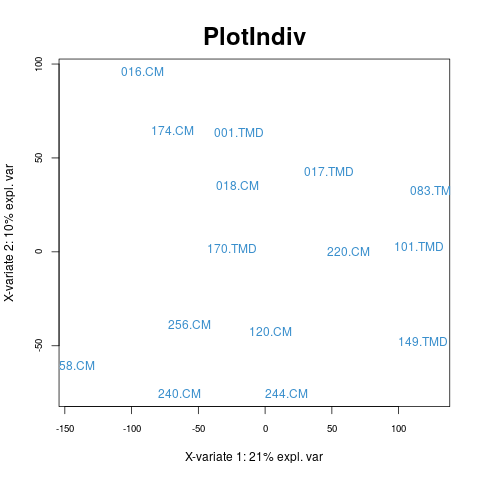

In [67]:
%%R
mixOmics::plotIndiv(p, comp = 1:2, rep.space = "X-variate",style="graphics",ind.names=TRUE)
points(Y_predict$variates[, 1], Y_predict$variates[, 2], pch = 19, cex = 1.2)
text(Y_predict$variates[, 1], Y_predict$variates[, 2], rownames(X_test), pos = 3)

### Using rOPLS

In [68]:
%R pca = ropls::opls(X_train);

PCA
15 samples x 34490 variables
standard scaling of predictors
12 excluded variables (near zero variance)
      R2X(cum) pre ort
Total    0.518   4   0


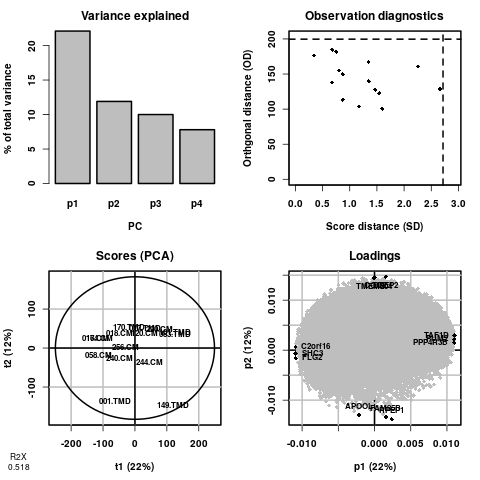

In [69]:
%R plot_summary(pca)

Building model fails with PLS of ropls package as well:

In [70]:
%R ropls::opls(X_train, as.matrix(Y_train))


Error: No model was built because the first predictive component was already not significant;
Select a number of predictive components of 1 if you want the algorithm to compute a model despite this.


In [71]:
%R -i ra -i pa

Even when using full data set (without putting the validation subset aside)

In [72]:
%R ropls::opls(ra, as.matrix(pa))


Error: No model was built because the first predictive component was already not significant;
Select a number of predictive components of 1 if you want the algorithm to compute a model despite this.


Though we can force usage of as many components as we like:

In [73]:
%R model = ropls::opls(ra, as.matrix(pa), predI=2);

PLS
21 samples x 34502 variables and 1329 responses
standard scaling of predictors and response(s)
      R2X(cum) R2Y(cum) Q2(cum) RMSEE pre ort
Total    0.259    0.315  0.0564 0.721   2   0


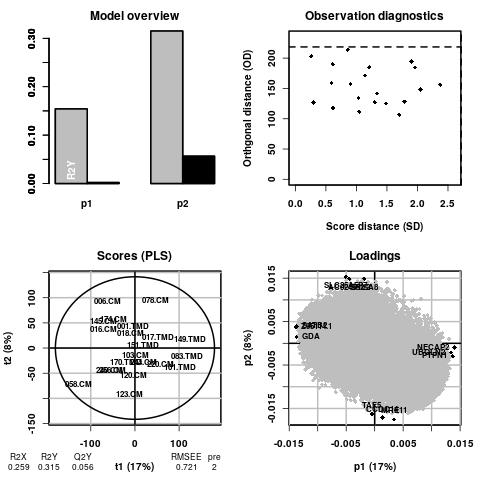

In [74]:
%%R -w 480 -h 480
plot_summary(model)

In [75]:
meningitis = clinical.loc[ra.index].Meningitis

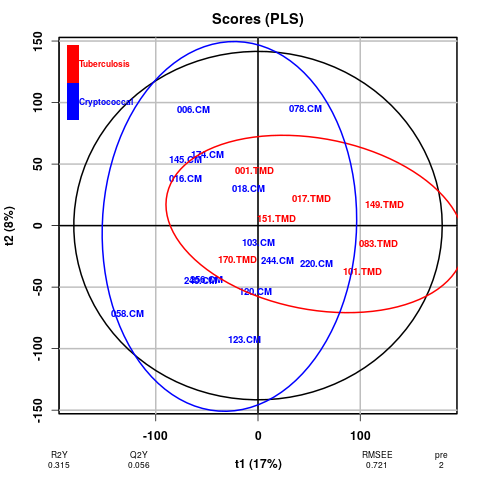

In [76]:
%%R -i meningitis
plot_opls(
    model, typeVc = "x-score", parAsColFcVn=meningitis,
    # does not work in this version yet... need to update bioconductor
    # parPaletteVc=as.character(patient_colors[['Meningitis']][unique(meningitis)])
)

In [77]:
%%R
# TODO create a better vis with ggplot using:
head(attr(model, 'scoreMN'))

                 p1        p2
001.TMD   -3.555905  44.55539
006.CM   -63.116696  94.33204
016.CM   -70.895253  38.23368
017.TMD   52.636491  22.00898
018.CM    -9.382544  29.87743
058.CM  -127.685171 -71.78473


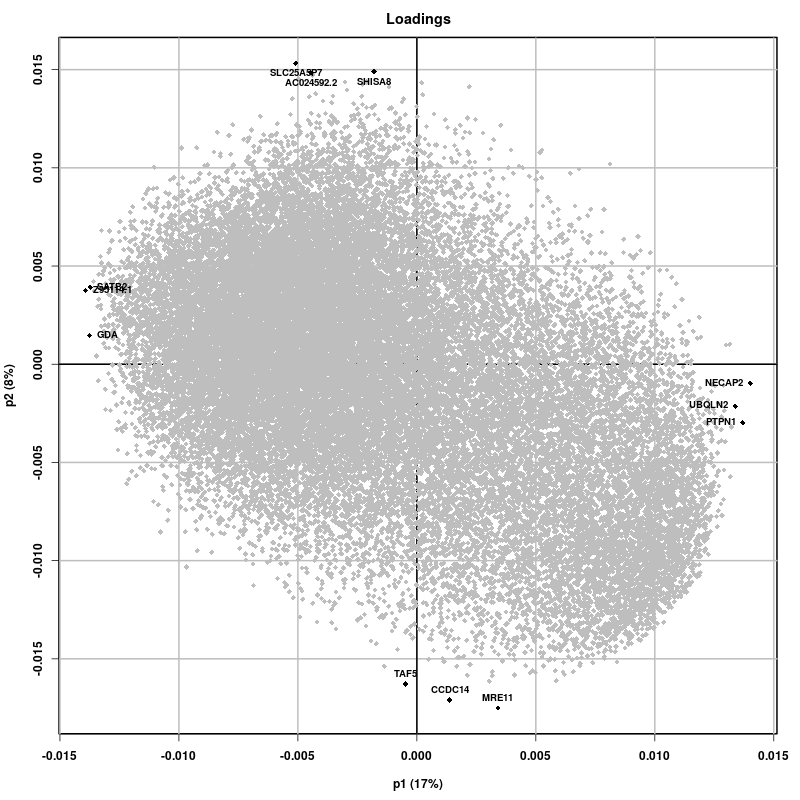

In [78]:
%R -w 800 -h 800 plot_opls(model, 'x-loading')

TODO: Look at those in differential correelations.
- projection; loadings/weights;
- VIP

While the model is not very good, it highlights some interesting genes which seem to align with more rather than fewer TMD patients:

The top 3:
- PTPN1: "Protein tyrosine phosphatase B (PtpB) is one of the virulence factors secreted into the host cell by Mycobacterium tuberculosis. PtpB attenuates host immune defenses by interfering with signal transduction pathways in macrophages and, therefore, it is considered a promising target for the development of novel anti-tuberculosis drugs." (https://www.ncbi.nlm.nih.gov/pubmed/24155919)
- UBQLN2: "UBQLN1 and UBQLN2 are thought to facilitate degradation of ubiquitinated targets by the proteasome UBQLN1 and UBQLN2 are thought to facilitate degradation of ubiquitinated targets by the proteasome [19,20]. More recently, they have also been shown to play a role in autophagy. Ubiquilins associate with autophagosomes, participate in autophagosome formation, and protect against starvation-induced cell death [21,22]." ... "Here, we show that UBQLN1 recognizes Mtb, acts upstream of ubiquitination, and promotes autophagy-mediated clearance of Mtb. Therefore, we provide evidence that UBQLN1 serves as a link between the bacterial surface and the host autophagy pathway." https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4520715/, 2015
- NECAP2: related to endocytosis, no mentions in context of TB

Unfortunately this package does not do OPLS for multivariate $Y$ :(

In [79]:
%R orthogonal_model = ropls::opls(ra, as.matrix(pa), predI=2, orthoI = NA);


Error: OPLS regression only available for a single 'y' response


## C) Early concatenation PLS-DA 

I can use rs/ps (to use shared subset) or ra/pa (to use all transcripts/proteins)

Proteins are encoded by .P suffix, transcripts by .R suffix: 

In [80]:
def concat_abundances(rna, protein):
    return pd.merge(
        rna.add_suffix('.R'), protein.add_suffix('.P'),
        left_index=T, right_index=T
    )

In [81]:
full_joined_rp = concat_abundances(rna=ra, protein=pa)
full_joined_rp.head(2)

,TSPAN6.R,DPM1.R,SCYL3.R,C1orf112.R,FGR.R,...,SERPINF1.P,CTSF.P,FTCD.P,USP25.P,PLXNB2.P
001.TMD,1.687826,-1.189430,4.956709,3.532492,6.941349,...,13.396705,6.172488,0.701885,1.291204,9.712462
006.CM,0.750583,2.436818,4.564363,-1.189430,6.874971,...,12.438645,6.207233,0.428609,1.374512,9.844042


In [82]:
joined_rp = concat_abundances(rna=rs.T, protein=ps.T)
joined_rp.head(2)

,FGR.R,CFH.R,BAD.R,CASP10.R,TFPI.R,...,CCL14.P,CCL3.P,HIST1H3F.P,HIST1H3C.P,HIST1H3H.P
001.TMD,6.941349,-1.189430,3.843445,6.973657,4.671722,...,7.349039,0.356692,6.274876,6.274876,6.274876
006.CM,6.874971,4.708614,2.436818,4.255382,4.920979,...,7.358052,0.489552,5.202891,5.202891,5.202891


In [83]:
assert all(joined_rp.index == full_joined_rp.index)

In [84]:
meningitis = clinical.loc[joined_rp.index].Meningitis

In [85]:
%R -i joined_rp -i meningitis

In [86]:
%R pca = ropls::opls(joined_rp);

PCA
21 samples x 2510 variables
standard scaling of predictors
      R2X(cum) pre ort
Total    0.556   5   0


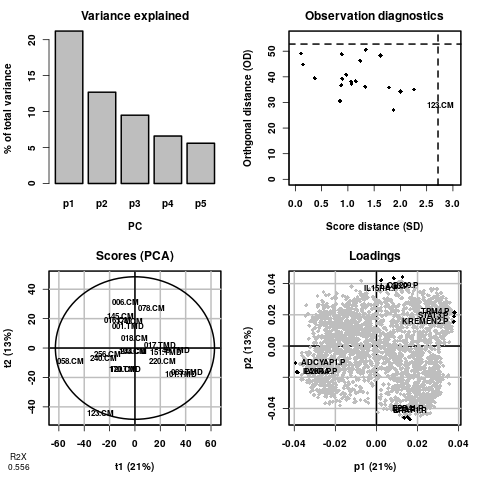

In [87]:
%R plot_summary(pca)

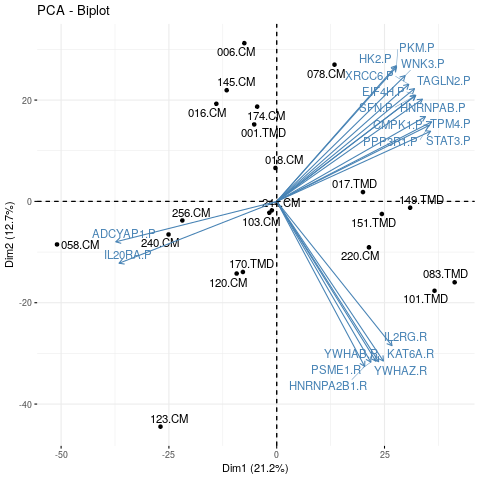

In [88]:
%%R
res.pca <- prcomp(joined_rp, scale = TRUE)
factoextra::fviz_pca_biplot(res.pca, repel = TRUE, select.var = list(cos2=20))

STAT3 sounds familiar (highlighted in 7.2)

In [89]:
%R model = ropls::opls(joined_rp, as.matrix(meningitis));

PLS-DA
21 samples x 2510 variables and 1 response
standard scaling of predictors and response(s)
      R2X(cum) R2Y(cum) Q2(cum)  RMSEE pre ort pR2Y  pQ2
Total    0.433    0.994   0.714 0.0425   4   0 0.15 0.05


In [90]:
%R -i full_joined_rp
%R full_model = ropls::opls(full_joined_rp, as.matrix(meningitis));

PLS-DA
21 samples x 35831 variables and 1 response
standard scaling of predictors and response(s)
      R2X(cum) R2Y(cum) Q2(cum) RMSEE pre ort pR2Y pQ2
Total    0.259    0.868   0.506 0.185   2   0  0.7 0.1


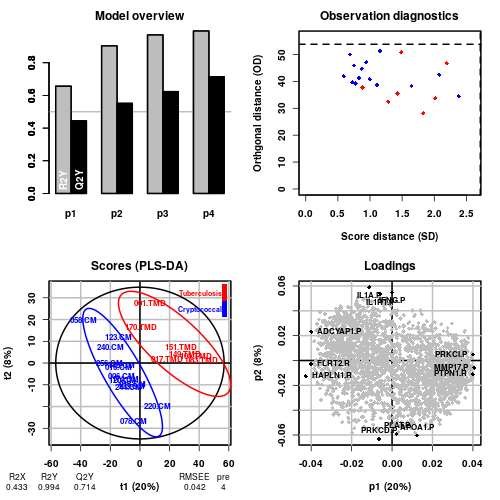

In [91]:
%%R -w 500 -h 500
plot_summary(model)

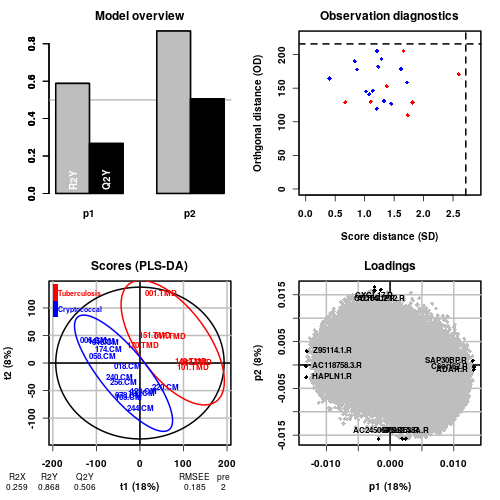

In [92]:
%%R -w 500 -h 500
plot_summary(full_model)

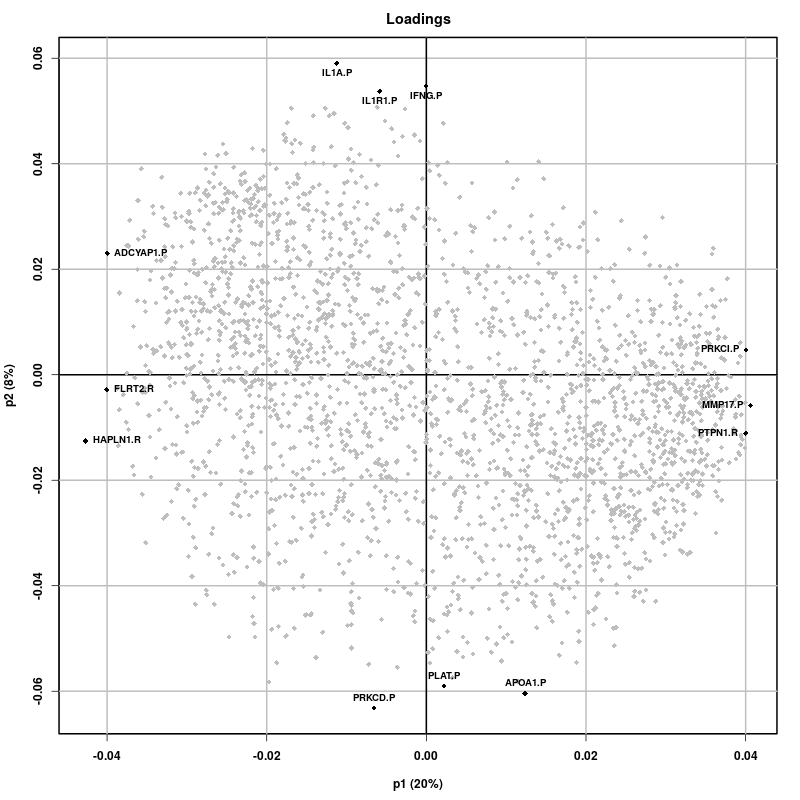

In [93]:
%%R -w 800 -h 800
plot_opls(model, "x-loading")

Show also protein if RNA is shown

- HAPLN1 supposedly innocent structural protein... "we identified a BMSC-secreted factor, hyaluronan and proteoglycan link protein 1 (HAPLN1), that can induce bortezomib-resistant NF-κB activity in MM cells. Specifically, HAPLN1 proteoglycan tandem repeat (PTR) domain 1 and 2 fragments have strong PIR NF-κB–inducing activities" (http://www.jbc.org/content/293/7/2452.full)
- which is in relation with IL1 on the other side of the graph. But I am not sure of exact interpretation: why is there more IL1/R - because those are over-expressed or because they are available for detection (as in contrast with those actively bound?) - some literature on the binding process and effect on SOMAScan needed

See https://els-jbs-prod-cdn.literatumonline.com/cms/attachment/4f047efc-b13e-4fe3-a08c-2c3b274f8b25/gr1.gif

Figure from https://www.cell.com/fulltext/S0092-8674(02)01166-2

- FLRT2 (which has highly positively correlated RNA-protein levels, see point 4)
- ADCYAP1 signal transduction, NGF signaling, [TODO I have this one in my search history it means it was highlighted earlier too]

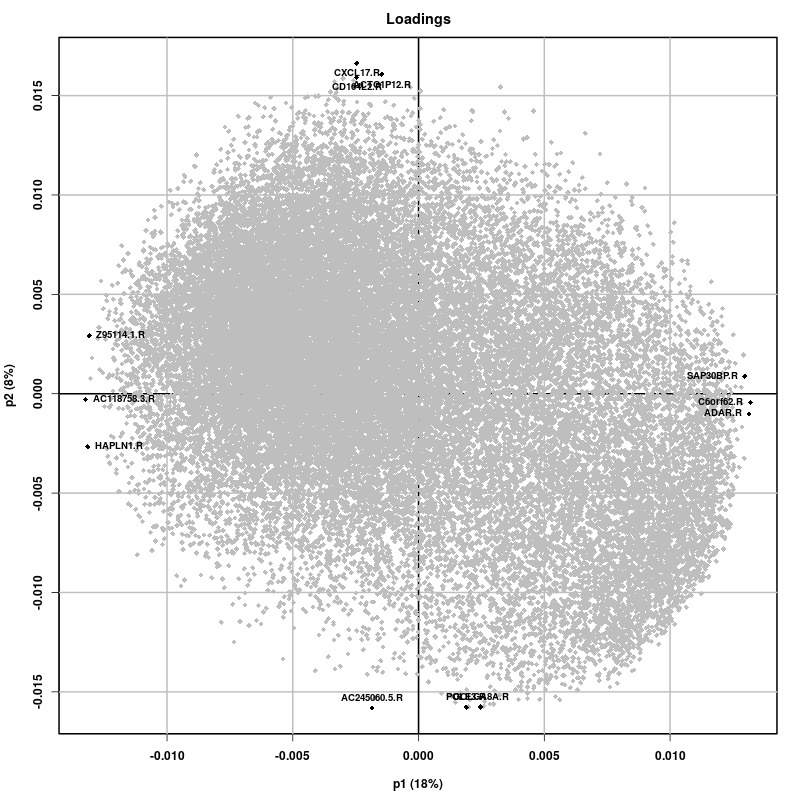

In [94]:
%%R -w 800 -h 800
plot_opls(full_model, "x-loading")

The full model performs worse which may be due to large amount of noise in the RNASeq data.
The specialized tools such as DSEq2 and limma-voom can filter or adjust for different phenomena specific to RNASeq but here it does not happen.
Possibly the best way forward would be to apply a more stringent filtering criterion (and not using everything as it is recommended for DESeq or limma and filtering later).

However what criteria would be objective for such a filtering?

Low variance - but which cutoff is right?

In [95]:
sum(full_joined_rp.var() < 1)

8054

On average fewer than one count - sounds ok (the initial filtering was considering all contrasts, it is still possible that considering other groups as well those gens could pass).

In [96]:
sum(full_joined_rp.mean() < 0)

5757

In [97]:
rp_filtered_by_mean = full_joined_rp[full_joined_rp.columns[full_joined_rp.mean() > 0]]
len(rp_filtered_by_mean.columns)

30139

In [98]:
sum(full_joined_rp.columns.str.endswith('P'))

1329

In [99]:
sum(rp_filtered_by_mean.columns.str.endswith('P'))

1280

reduction from 35k to 30k, mostly in RNASeq transcripts

In [100]:
%R -i rp_filtered_by_mean
%R mean_filtered_model = ropls::opls(rp_filtered_by_mean, as.matrix(meningitis));

PLS-DA
21 samples x 30081 variables and 1 response
standard scaling of predictors and response(s)
      R2X(cum) R2Y(cum) Q2(cum) RMSEE pre ort pR2Y pQ2
Total    0.282    0.841   0.482 0.203   2   0  0.8 0.1


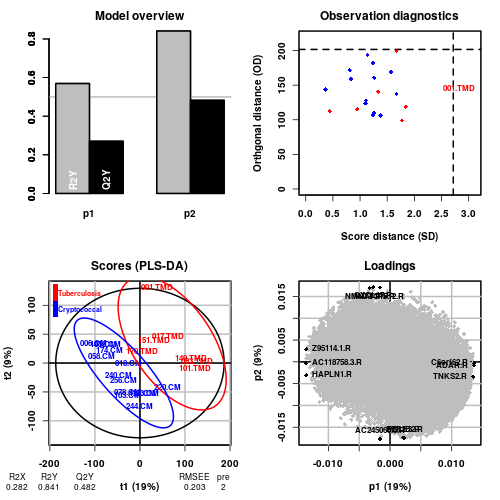

In [101]:
%%R -w 500 -h 500
plot_summary(mean_filtered_model)

not much better...

TODO: 001.TMD looks like an outlier (and always looked like one) - reject it?

#### With validation

In [102]:
%%R
# TODO: sacrificing half of the data is a bit too much... is there a way to enforce other split with this package?
val_model = ropls::opls(joined_rp, as.matrix(meningitis), subset='odd', crossvalI=7);

PLS-DA
11 samples x 2510 variables and 1 response
standard scaling of predictors and response(s)
      R2X(cum) R2Y(cum) Q2(cum) RMSEE RMSEP pre ort
Total    0.283    0.955   0.496 0.119 0.266   2   0


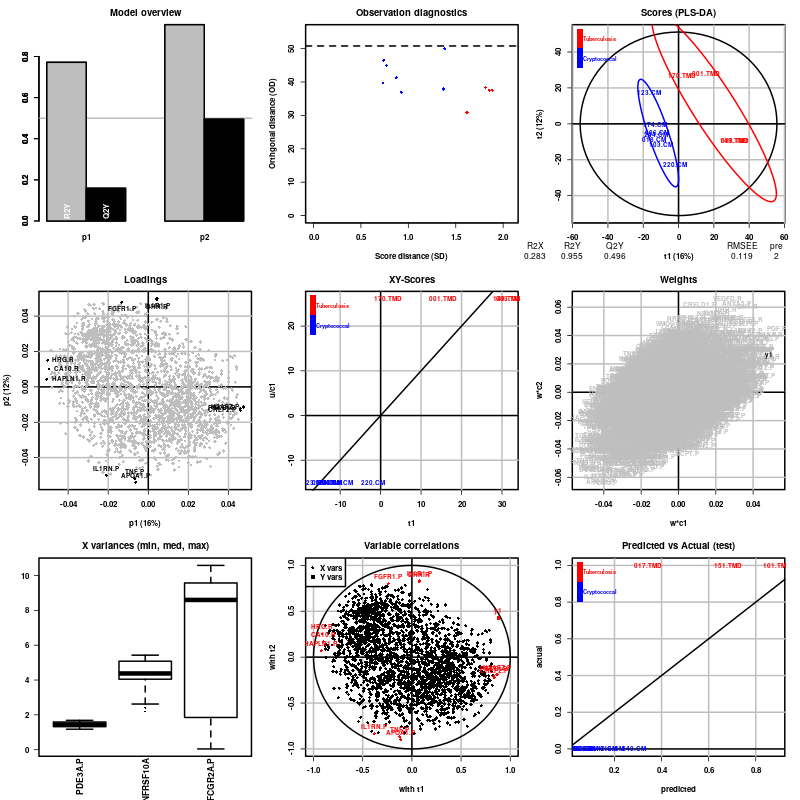

In [103]:
%%R -w 800 -h 800
plot_opls_all(val_model, test=T)

TODO: Predicted vs Actual is not very useful, ROC would be much better.

In [104]:
#library(plotROC)
#basicplot <- ggplot(test, aes(d = D, m = M1)) + geom_roc()

TODO: use remaining TB patients for validation?

The model train on reduced number of patients still recovers similar proteins:

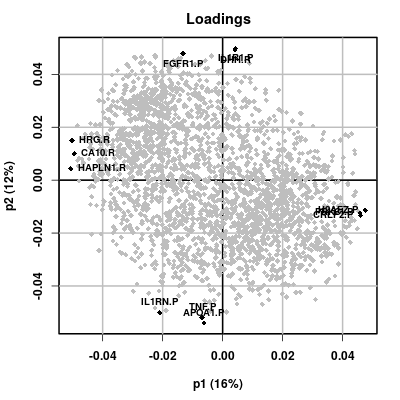

In [105]:
%%R -w 400 -h 400
plot_opls(val_model, "x-loading")

But is it better than doing things separately?

TOOD: pathway analysis

OmicsPLS for O2PLS

## D) Late integration DA (separate PLS-DA for TMD and for CM)

In [106]:
rst = rs.T
pst = ps.T

In [107]:
%R -i rst -i pst

In [108]:
%R model_rna_subset = ropls::opls(rst, as.matrix(meningitis));

PLS-DA
21 samples x 1255 variables and 1 response
standard scaling of predictors and response(s)
      R2X(cum) R2Y(cum) Q2(cum) RMSEE pre ort pR2Y pQ2
Total    0.344    0.794   0.404 0.231   2   0  0.4 0.1


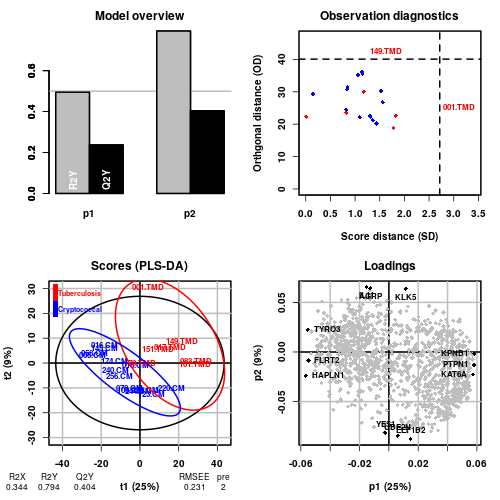

In [109]:
%%R -w 500 -h 500
plot_summary(model_rna_subset)

In [110]:
%R model_protein_subset = ropls::opls(pst, as.matrix(meningitis));

PLS-DA
21 samples x 1255 variables and 1 response
standard scaling of predictors and response(s)
      R2X(cum) R2Y(cum) Q2(cum)  RMSEE pre ort pR2Y  pQ2
Total    0.574    0.989   0.845 0.0556   4   0 0.05 0.05


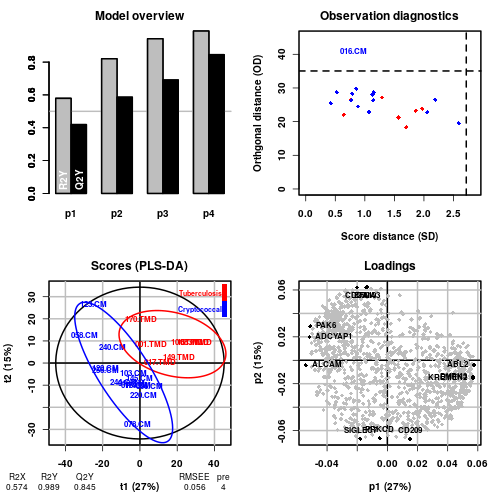

In [111]:
%%R -w 500 -h 500
plot_summary(model_protein_subset)

In [112]:
(0.845 + 0.404) / 2

0.6245

TODO: cd4 + hiv